# Simple Linear Regression with TensorFlow Probability

In this notebook we show how to fit a simple linear regression model using [TensorFlow Probability](https://www.tensorflow.org/probability) by replicating the first example on the [getting started guide for PyMC3](https://docs.pymc.io/notebooks/getting_started.html). We are going to use [Auto-Batched Joint Distributions](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionCoroutineAutoBatched) as they simplify the model specification considerably. Moreover, there is a great resource to get deeper into this type of distribution: [Auto-Batched Joint Distributions: A Gentle Tutorial](https://www.tensorflow.org/probability/examples/JointDistributionAutoBatched_A_Gentle_Tutorial), which I **strongly recommend** (see [this post](https://juanitorduz.github.io/intro_tfd/) to get a brief introduction on TensorFlow probability distributions). In addition the tutorial: [Bayesian Modeling with Joint Distribution](https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution) is also a great reference to get started with linear models in TensorFlow Probability.

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
import arviz as az

# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Get TensorFlow version.
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')

TnesorFlow version: 2.7.0
TnesorFlow Probability version: 0.15.0


In [2]:
%load_ext watermark
%watermark --iversions

matplotlib            : 3.4.3
tensorflow_probability: 0.15.0
tensorflow            : 2.7.0
arviz                 : 0.11.2
numpy                 : 1.19.5
seaborn               : 0.11.2
pandas                : 1.3.2



In [3]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Generate Data

We generate the data as in the PyMC3 example: 

$$y = \alpha + \beta_0 x_0 + \beta_1 x_1 + \varepsilon \quad \text{where}\quad \varepsilon \sim N(0, \sigma^2)$$

In [4]:
np.random.seed(42)
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]
# Size of dataset
size = 100
# Predictor variable
x0 = np.random.randn(size)
x1 = np.random.randn(size) * 0.2
# Simulate outcome variable
y = alpha + beta[0] * x0 + beta[1] * x1 + np.random.randn(size) * sigma

Let us plot the distribution of the target variable.

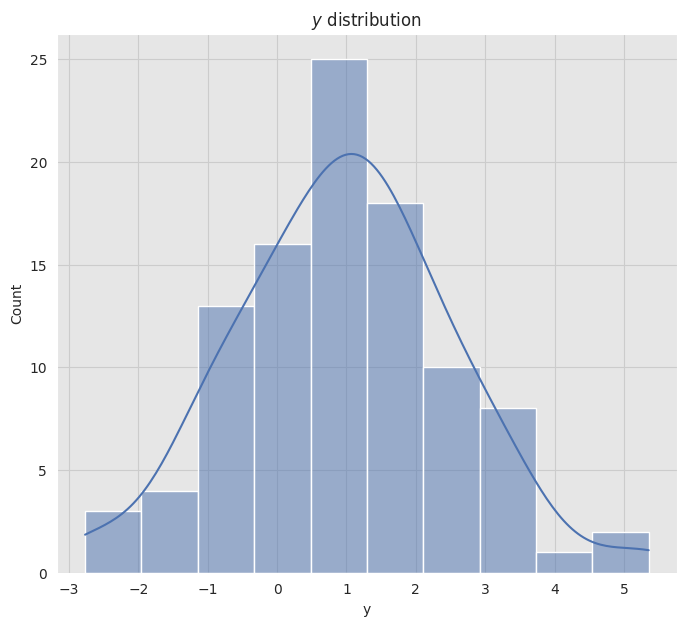

In [5]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.histplot(x=y, kde=True, ax=ax)
ax.set(title='$y$ distribution', xlabel='y');

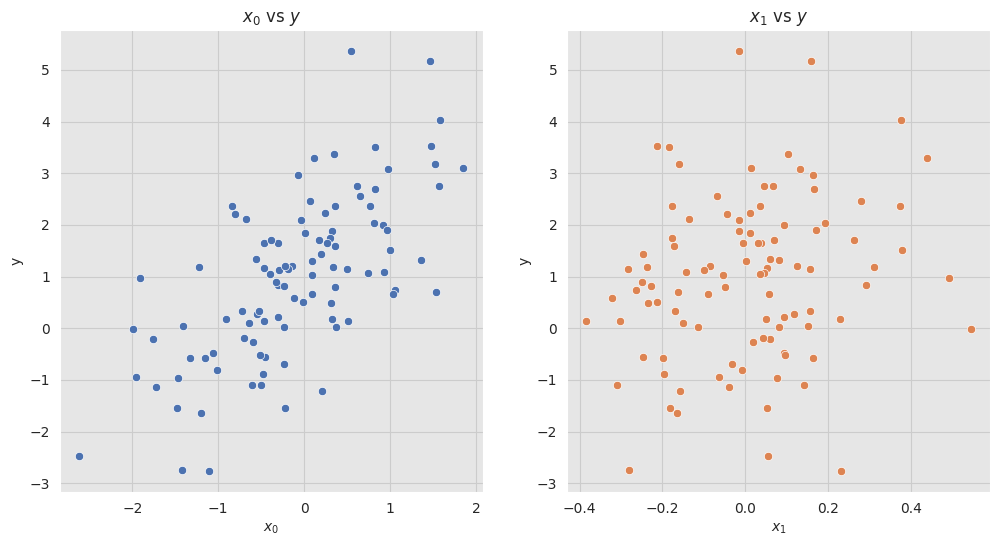

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2)
sns.scatterplot(x=x0, y=y, color=sns_c[0], ax=ax[0])
sns.scatterplot(x=x1, y=y, color=sns_c[1], ax=ax[1])
ax[0].set(title='$x_0$ vs $y$', xlabel='$x_0$', ylabel='y')
ax[1].set(title='$x_1$ vs $y$', xlabel='$x_1$', ylabel='y');

## Define Model

Our model is 

$$
y \sim N(\mu, \sigma^2) \\
\mu = \alpha + \beta_0 x_0 + \beta_1 x_1
$$
with the priors 
$$
\alpha \sim N(0, 100) \\
\beta_i \sim N(0, 100) \\
\sigma \sim |N(0, 1)|
$$

In order to define the model in TensorFlow Probability let us first convert our input into [tf tensors](https://www.tensorflow.org/api_docs/python/tf/Tensor). 

In [7]:
# Set seed.
tf.random.set_seed(42)
# Set tensor numeric type.
dtype = 'float32'

x = np.stack([x0, x1], axis=1)
x = tf.convert_to_tensor(x, dtype=dtype)

y = tf.convert_to_tensor(y, dtype=dtype)
y = tf.reshape(y, (-1, 1))

Next, we define our model distribution using [Auto-Batched Joint Distributions](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionCoroutineAutoBatched). Note how similar the model specification is to the mathematical definition. 

$$
y \sim N(\mu, \sigma^2) \\
\mu = \alpha + \beta_0 x_0 + \beta_1 x_1
$$
with the priors 
$$
\alpha \sim N(0, 100) \\
\beta_i \sim N(0, 100) \\
\sigma \sim |N(0, 1)|
$$

In [8]:
jds_ab = tfd.JointDistributionNamedAutoBatched(dict(

    sigma=tfd.HalfNormal(scale=[tf.cast(1.0, dtype)]),

    alpha=tfd.Normal(
        loc=[tf.cast(0.0, dtype)], 
        scale=[tf.cast(10.0, dtype)]
    ),

    beta=tfd.Normal(
        loc=[[tf.cast(0.0, dtype)], [tf.cast(0.0, dtype)]], 
        scale=[[tf.cast(10.0, dtype)], [tf.cast(10.0, dtype)]]
    ),

    y=lambda beta, alpha, sigma: 
        tfd.Normal(
            loc=tf.linalg.matmul(x, beta) + alpha, 
            scale=sigma
        ) 
))

## Prior Simulations

Next, before fitting the model, we want to generate predictions with the prior distributions. 

In [9]:
# Sample from the prior.
prior_samples = jds_ab.sample(500)#['y']

+ [Bayesian workflow with TFP and arviz](https://jeffpollock9.github.io/bayesian-workflow-with-tfp-and-arviz/)

In [10]:
idata = az.from_dict(prior_predictive=prior_samples)
idata

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/base.py:169: UserWarning: More chains (500) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/base.py:169: UserWarning: More chains (500) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/base.py:169: UserWarning: More chains (500) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Inference data with groups:
	> prior_predictive

In [11]:
# print(prior_samples)

In [12]:
prior_samples = prior_samples['y']

In [13]:
# print(prior_samples)

Let us plot the predictions against the true values of $y$ with the corresponding credible intervals ($\mu \pm 2\sigma$).

(500, 100, 1)
(500, 100)


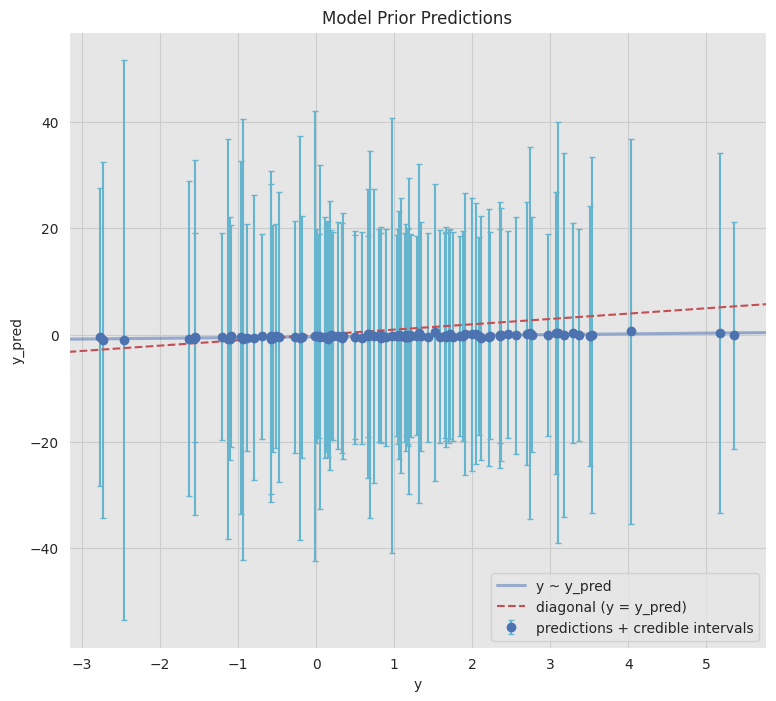

In [14]:
print(prior_samples.shape)
prior_samples = tf.squeeze(prior_samples)
print(prior_samples.shape)
prior_mean = tf.math.reduce_mean(prior_samples, axis=0).numpy()
prior_std = tf.math.reduce_std(prior_samples, axis=0).numpy()

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar(
    x=tf.squeeze(y).numpy(), 
    y=prior_mean, 
    yerr=2*prior_std,
    fmt='o',
    ecolor=sns_c[9],
    capsize=2,
    label='predictions + credible intervals',
)
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=prior_mean, 
    color=sns_c[0], 
    scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
ax.axline(xy1=(0,0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Prior Predictions', xlabel='y', ylabel='y_pred');

We see that the priors are very flat and the range for predictions is very wide. 

**Remark:** In many applications one would like to restrict the priors a little bit more to encode domain knowledge information.

## Fit Model

Now we fit the model using [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) (see [this post](https://juanitorduz.github.io/tfp_hcm/) for another example). 

First, we need to define the target function, which in this case is simply the log-probability.

In [15]:
def target_log_prob_fn(beta=beta, alpha=alpha, sigma=sigma):
    return jds_ab.log_prob(beta=beta, alpha=alpha, sigma=sigma, y=y)

Secondly, we specify the sampling method:

In [16]:
# Size of each chain.
num_results = int(1e4)
# Burn-in steps.
num_burnin_steps = int(1e3)
# Hamiltonian Monte Carlo transition kernel. 
# In TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=1.0,
  num_leapfrog_steps=3
  
)
# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)
# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in). 
  # Implements MCMC via repeated TransitionKernel steps.
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.convert_to_tensor([[1.0], [1.0]], dtype=dtype),
          tf.convert_to_tensor([1.0], dtype=dtype), 
          tf.convert_to_tensor([1.0], dtype=dtype)
      ],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
    return samples

Finally, we run the sampling 5 times. 

In [17]:
# Set number of chains. 
num_chains = 5
# Run sampling. 
chains = [run_chain() for i in range(num_chains)]

## Visualize Posterior Distributions

Let us collect and format the chains output for visualization. 

**Remark:** There are many (better) ways to format the output of the sampling. In addition, one could use [ArviZ](https://arviz-devs.github.io/arviz/index.html) to generate the visualization. For now we just stick to [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/).

In [18]:
chains_t = list(map(list, zip(*chains)))

chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]

In [19]:
chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1
)

params = ['beta_0', 'beta_1', 'alpha', 'sigma']
chains_df.columns = params

chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % num_results,
        chain_id=lambda x: (x['sample_id'] / num_results).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    

chains_df.head()

,beta_0,beta_1,alpha,sigma,sample_id,chain_sample_id,chain_id
0,1.230113,2.688856,1.062919,1.016138,0,0,c_1
1,1.239078,2.463629,1.116013,1.067487,1,1,c_1
2,1.213967,2.305331,1.070029,1.183648,2,2,c_1
3,1.245077,1.774402,1.094792,1.071390,3,3,c_1
4,1.166324,1.924036,1.126412,1.101972,4,4,c_1


Let us plot the posterior distributions of the model parameters per chain:

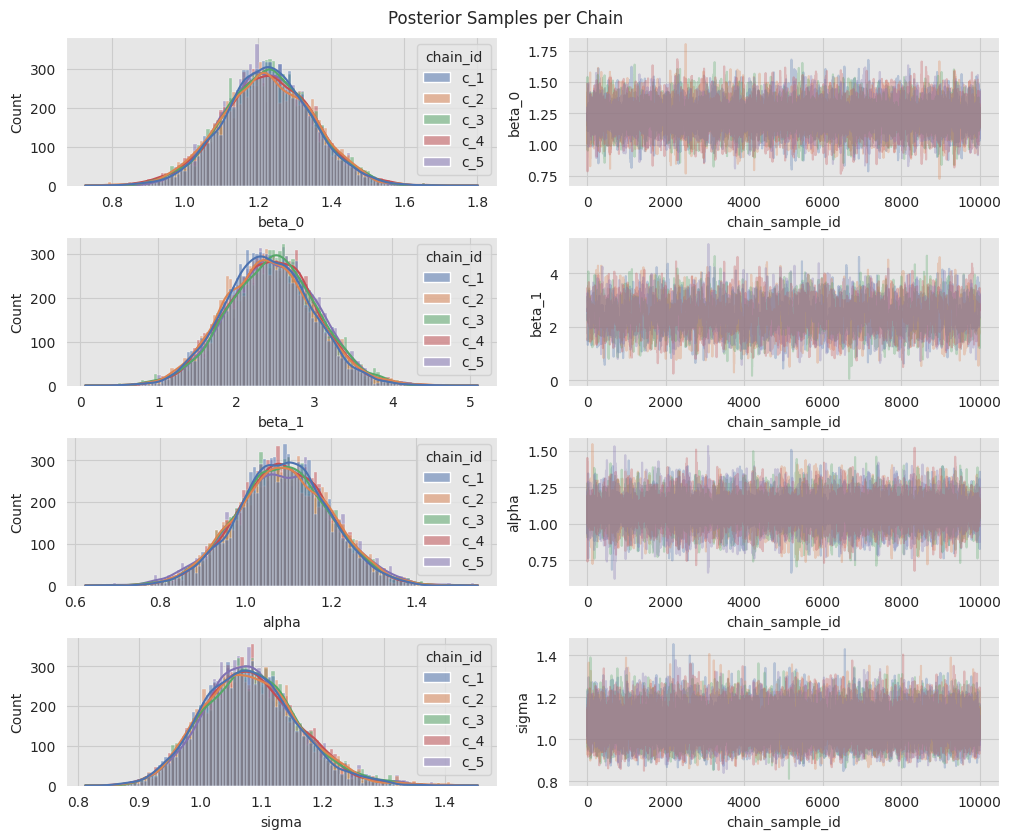

In [20]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.3, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03);

Now we generate the sample plot but with all the chains combined.

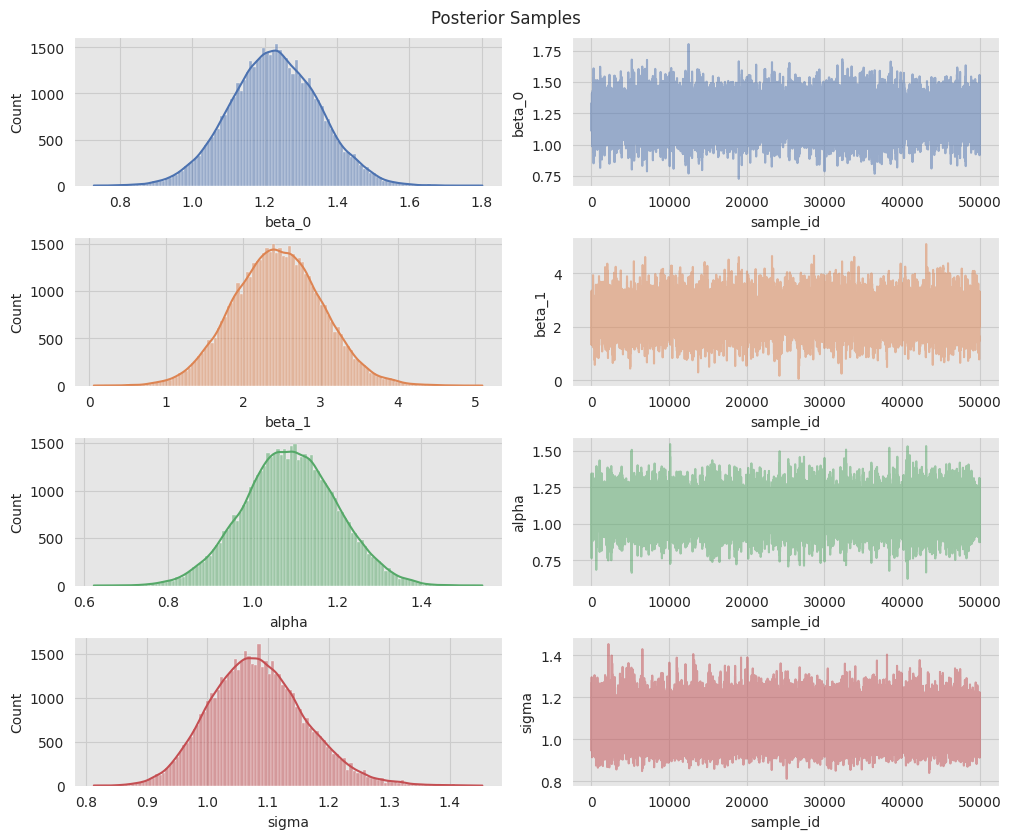

In [21]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, color=sns_c[i], kde=True, ax=axes[i][0])
    sns.lineplot(x='sample_id', y=param, data=chains_df, color=sns_c[i], alpha=0.5, ax=axes[i][1])

fig.suptitle('Posterior Samples', y=1.03);

The chains seems to have converged. 

## Generate Predictions

### In-Sample

We want to see the model (in-sample) predictions. We begin by sampling from the distribution mean $\mu$ (that is, we ignore $\sigma$).

In [22]:
# Here we compute mu = alpha + beta x.
mu_posterior_samples = tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.ones(shape=(1, x.shape[0]))) \
    + tf.linalg.matmul(chains_samples[0], tf.transpose(x)) 

Let us plot the results:

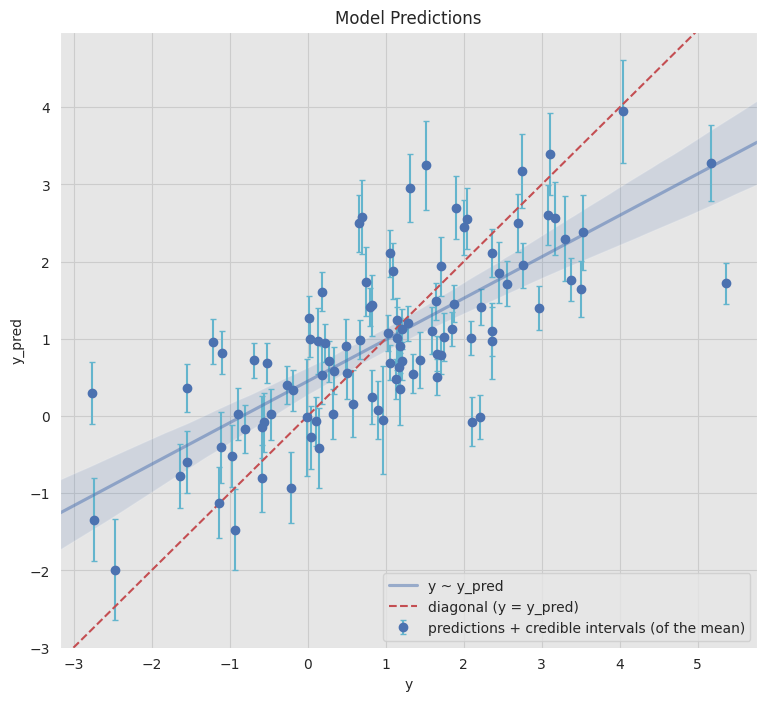

In [23]:
mu_posterior_mean = tf.math.reduce_mean(mu_posterior_samples, axis=0).numpy()
mu_posterior_std = tf.math.reduce_std(mu_posterior_samples, axis=0).numpy()

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar(
    x=tf.squeeze(y).numpy(), 
    y=mu_posterior_mean, 
    yerr=2*mu_posterior_std,
    fmt='o',
    ecolor=sns_c[9],
    capsize=2,
    label='predictions + credible intervals (of the mean)'
)
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=mu_posterior_mean, 
    color=sns_c[0], 
    scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
ax.axline(xy1=(0,0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Predictions', xlabel='y', ylabel='y_pred');

Now let us generate (in-sample) predictions by sampling from $N(\mu, \sigma)$. 

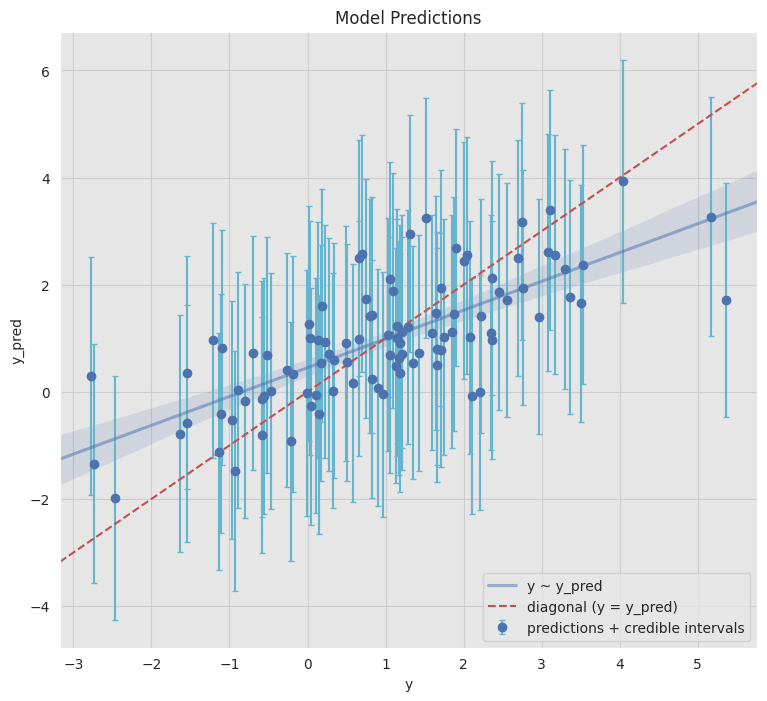

In [24]:
pred_samples = tf.map_fn(
    fn=lambda z: tfd.Normal(loc=z, scale=chains_samples[2]).sample(1), 
    elems=tf.transpose(mu_posterior_samples)
)

pred_samples = tf.squeeze(pred_samples)

posterior_mean = tf.math.reduce_mean(pred_samples, axis=1).numpy()
posterior_std = tf.math.reduce_std(pred_samples, axis=1).numpy()

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar(
    x=tf.squeeze(y).numpy(), 
    y=posterior_mean, 
    yerr=2*posterior_std,
    fmt='o',
    ecolor=sns_c[9],
    capsize=2,
    label='predictions + credible intervals',
)
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=mu_posterior_mean, 
    color=sns_c[0], 
    scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
ax.axline(xy1=(0,0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Predictions', xlabel='y', ylabel='y_pred');

### Out-Sample

Finally let us generate an out-sample. prediction for the vector 

$$
x_* =
\left(
\begin{array}{c}
3 \\
1
\end{array}
\right)
$$

Again, remember we are not interested in the point prediction but rather on the complete posterior distribution.

In [25]:
x_star = tf.cast([[3.0, 1.0]], dtype)
# Here we compute mu = alpha + beta x.
mu_y_star = tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.ones(shape=(1, x_star.shape[0]))) \
    + tf.linalg.matmul(chains_samples[0], tf.transpose(x_star)) 
# Compute posterior predictive distribution.
y_star_samples = tf.map_fn(
    fn=lambda z: tfd.Normal(loc=z, scale=chains_samples[2]).sample(1), 
    elems=tf.transpose(mu_y_star)
)

Let us not generate samples from the "true" distribution:

In [26]:
# Point prediction of the mean.
y_star_true = tf.linalg.matmul(x_star, tf.transpose(tf.cast([beta], dtype))) + alpha
y_star_true  = y_star_true.numpy().flatten()
# Sample from the complete posterior predictive distribution.
y_star_true_samples =tfd.Normal(loc=y_star_true, scale=sigma).sample(num_chains * num_results)
y_star_true_samples = y_star_true_samples.numpy().flatten()
# Mean of the complete posterior predictive distribution.
y_star_true_samples_mean = tf.reduce_mean(y_star_samples, axis=2).numpy().flatten()

Now we plot the results: 

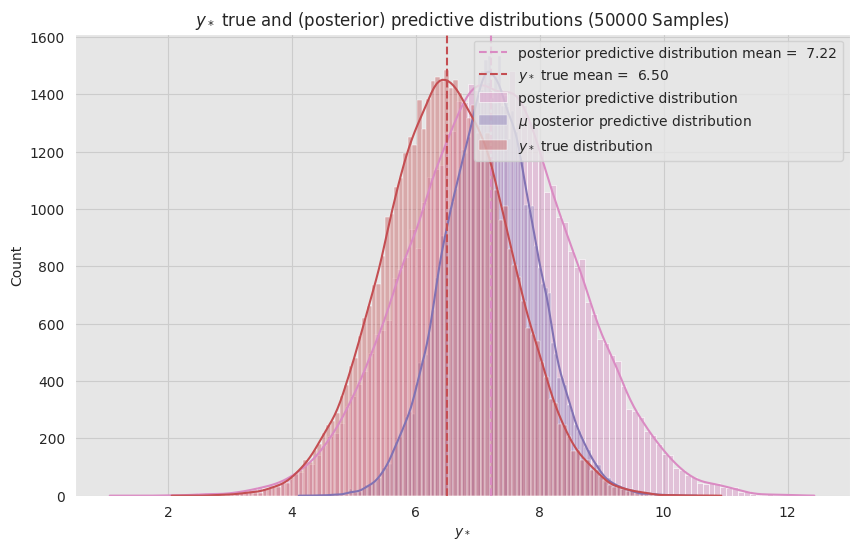

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    x=tf.squeeze(y_star_samples).numpy(), 
    kde=True, 
    color=sns_c[6], 
    alpha=0.4,
    label='posterior predictive distribution', 
    ax=ax
)
ax.axvline(
    x=y_star_true_samples_mean, 
    color=sns_c[6], 
    linestyle='--', 
    label=f'posterior predictive distribution mean = {y_star_true_samples_mean[0]: 0.2f}'
)
sns.histplot(
    x=mu_y_star.numpy().flatten(), 
    kde=True,
    color=sns_c[4], 
    alpha=0.4,
    label='$\mu$ posterior predictive distribution', 
    ax=ax
)
sns.histplot(
    x=y_star_true_samples, 
    kde=True,
    color=sns_c[3], 
    alpha=0.4,
    label='$y_*$ true distribution', 
    ax=ax
)
ax.axvline(
    x=y_star_true, 
    color=sns_c[3], 
    linestyle='--', 
    label=f'$y_*$ true mean = {y_star_true[0]: 0.2f}'
)
ax.legend(loc='upper right')
ax.set(
    title=f'$y_*$ true and (posterior) predictive distributions ({num_chains * num_results} Samples)',
    xlabel=f'$y_*$'
);

- The **red** distribution is the "true" one which we get by sampling from $N(\mu_*, \sigma)$, where $\mu_* = \alpha + \beta x_*$ (known values of $\alpha$ and $\beta$).

- The **purple** distribution is the one of the mean posterior samples of $\hat{\mu}_* = \hat{\alpha} + \hat{\beta} x_*$. Here $\hat{\alpha}$ and $\hat{\beta}$ denote samples from the posterior. 

- The **pink** distribution is the complete posterior predictive distribution, i.e. $N(\hat{\mu}_*, \hat{\sigma}^2)$.
